In [148]:
import importlib
import os
import ipywidgets as wd
import numpy as np
import pandas as pd
import sympy as sp
import qgrid as qg
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

from itertools import product
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from pathlib import Path
from functools import reduce
import operator
from sympy.utilities.lambdify import implemented_function, lambdify
from scipy import stats
from plotly import tools as plotly_tools
import plotly.io as pio

import utils.plot_utils as pu


idx = pd.IndexSlice

sp.init_printing()
py.init_notebook_mode(connected=True)
qg.set_defaults(show_toolbar=True)
qg.enable()

## Define data paths

In [146]:
efficienciesPath = Path("./data/RT-qPCR/Efficiencies.csv")
qpcrsPath = Path("./data/RT-qPCR/Cts.csv")
sampleTimePath = Path("./data/sample-times_CO2H2.csv")

outPath = Path("./intermediate/Comparative_Expression")
results_path = Path("./results/CO2-H2")

## Load the efficiencies into a dataframe

In [3]:
efficiencies = pd.read_csv(efficienciesPath, index_col=0)
efficiencies = efficiencies["Efficiency"]
efficiencies

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Load the original qPCR data into a dataframe

In [4]:
originalCts = pd.read_csv(qpcrsPath, parse_dates=True)
originalCts.Date = pd.to_datetime(originalCts.Date)

originalCts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Rename columns and sort

In [5]:
cts = originalCts.copy().rename({
    "Sample": "ID",
    "Target": "GOI",
    "Cq": "Ct"
}, axis=1)

cts.loc[cts.loc[:,"ID"].notnull(), "Sample"] = cts.loc[cts.loc[:,"ID"].notnull(), "ID"].str[1:]
cts.loc[cts.loc[:,"ID"].notnull(), "Bottle"] = cts.loc[cts.loc[:,"ID"].notnull(), "ID"].str[0]

sample_dtype = pd.api.types.CategoricalDtype(
    categories=[i for i in range(1, 13)], 
    ordered=True
)

cts.Sample = pd.to_numeric(cts.Sample).astype(sample_dtype)
cts.Content = cts.Content.astype("category")
cts.Bottle = cts.Bottle.astype("category")
cts.GOI = cts.GOI.astype("category")

cts = cts.reindex(
    labels=["Content", "Sample", "GOI", "Bottle", "Date", "Ct", "Well"],
    axis="columns"
).sort_values(
    ["Content", "Sample", "GOI", "Bottle"]
)

cts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Have a look at NRTs vs samples

They should differ on average by 10 or more

In [6]:
NRTs = cts[cts.Content == "NRT"].Ct
Unkns = cts[(cts.Content == "Unkn") & (cts.GOI == "gyrA")].Ct

pd.Series({
    "NRTs": NRTs.mean(),
    "Unkns": Unkns.mean()
})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [153]:
fig = px.scatter(
    cts.loc[cts.GOI == "gyrA"].rename(
        {
            "Ct": "CT"
        },
        axis="columns"
    ).assign(
        Sample=lambda df: df.Sample.map(lambda s: "P"+str(s))
    ),
    x="Sample",
    y="CT",
    color="Content",
    marginal_y="box",
    template="plotly_white"
)

pio.write_image(fig, str(results_path / 'nrt-vs-unkn.svg'))
fig

## Label the data entries with their respective experiment type according to bottle name

In [8]:
exp_dtype = pd.api.types.CategoricalDtype(
    categories=["pressure", "control"], 
    ordered=True
)

exp_from_bottle_col = lambda bottle: (
    np.where(
        bottle.isin(["A", "B", "C", "D"]), 
        "control", 
        np.where(
            bottle.isin(["E", "F", "G", "H"]), 
            "pressure", 
            float("NaN")
        )
    )
)

cts = cts.assign(Exp_Type=(lambda x: exp_from_bottle_col(x.Bottle)))

cts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Calculate Mean of triplicate experiments

In [9]:
meanCts = cts[cts.Content == "Unkn"].groupby(by=["Sample", "GOI", "Exp_Type"]).agg({"Ct": ["mean", "std"]})

meanCts.columns = ["Ct_mean", "Ct_std"]

meanCts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Have a look on how Ct_mean and Ct_std correlate

In [10]:
py.iplot(pu.scatterplot_from_df(meanCts.reset_index(), "Ct_mean", "Ct_std", nameCols=["Sample", "GOI"]))

## Plot Ct_mean and Ct_std for all samples and genes

In [11]:
traces = [
    go.Bar(
        x=df.GOI,
        y=df.Ct_mean,
        error_y=dict(
            type='data',
            array=df.Ct_std,
            visible=True
        ),
        name=("Sample: %s, Type: %s"%(sample, expType)),
        marker=dict(
            color=('rgb(30, 150, 255)' if expType == "control" else 'rgb(55, 95, 150)')
        )
    )
    for sample, outerDf in meanCts.reset_index().groupby(by="Sample")
    for expType, df in outerDf.groupby(by="Exp_Type") 
]

unique_samples = meanCts.reset_index()["Sample"].unique().map(lambda s: "Sample: %s"%s)

fig = plotly_tools.make_subplots(rows=len(unique_samples), cols=1, subplot_titles=unique_samples)

for i, trace in enumerate(traces):
    yi = int(np.floor(i/2)+1)
    fig.append_trace(trace, yi, 1)
    fig['layout']['yaxis'+str(yi)].update(title='Ct mean [-]')
    
fig['layout'].update(height=1500)
    
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]
[ (6,1) x6,y6 ]



## Extract all Ct values (no mean) and label them with their respective replica (1-3)

In [12]:
def assignReplica(b):
    return np.where(
        b.isin(["A", "E"]), 
        1,
        np.where(
            b.isin(["B", "F"]), 
            2, 
            np.where(
                b.isin(["C", "G", "D", "H"]),
                3,
                float("NaN")
            )
        )
    )

sampleCts = cts.loc[
    cts.Content == "Unkn", ["Sample", "GOI", "Exp_Type", "Bottle", "Ct"]
].assign(
    Replica=lambda x: assignReplica(x.Bottle)
).set_index(
    ["Sample", "GOI", "Exp_Type", "Replica"]
)

sampleCts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Distribution of Ct values for all genes

In [149]:
fig = px.scatter(
    sampleCts.reset_index(
    ).assign(
        **{
            "Unique Sample": lambda df: df.Bottle.str.cat(df.Sample.map(str))
        }
    ).sort_values(
        ["Sample", "Bottle"]
    ),
    y="Ct",
    color="GOI",
    x="Unique Sample",
    marginal_y="box",
    template="plotly_white",
    width=1200,
    labels={
        "Ct": "$C_T$",
        "GOI": "Gene"
    }
)

pio.write_image(fig, str(results_path / 'all-cts.svg'))
fig

## Calculate stability M for all genes

In [90]:
def calculate_M(df, g):
    def calculate_V(df_var):
        return pd.Series(df.Ct.values - df_var.Ct.values).std()

    s = pd.Series(
        { 
            "V_"+gene: calculate_V(df_var) for gene, df_var in g if gene != df.name
        }
    )
        
    s.at["M"] = s.mean()
        
    return s
    

Ms = sampleCts.reset_index(
).groupby(
    by="GOI"
).pipe( 
    lambda g: g.apply(calculate_M, g) 
).unstack()

Ms

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [152]:
fig = px.bar(
    Ms.reset_index(),
    y="M",
    x="GOI",
    color="GOI",
    template="plotly_white",
    labels={
        "GOI": "Gene",
        "M": "Stability M"
    }
)

pio.write_image(fig, str(results_path / 'stability-m.svg'))
fig

## Define Mathematical Expression used to calculate ddCt

In [14]:
E_goi, E_ref, Ct_calib, Ct_sample, Ct_goi, Ct_ref, RelExp, RelExp_calib, RelExp_sample, CompExp = sp.symbols(
    "E_goi E_ref Ct_calib Ct_sample Ct_goi Ct_ref RelExp RelExp_calib RelExp_sample CompExp"
)
dCt = sp.Symbol("\Delta Ct")
ddCt = sp.Symbol("\Delta \Delta Ct")
dCt_goi = sp.Symbol("\Delta Ct_{goi}")
dCt_ref = sp.Symbol("\Delta Ct_{ref}")

In [15]:
dCtEq = sp.Eq(
    dCt,
    Ct_calib - Ct_sample
)

dCtEq

In [16]:
ddCtEq = sp.Eq(
    ddCt,
    ((1+E_goi)**dCt_goi) /
    ((1+E_ref)**dCt_ref)
)

ddCtEq

In [17]:
RelExpEq = sp.Eq(
    RelExp,
    ((1+E_ref)**Ct_ref) / 
    ((1+E_goi)**Ct_goi)
)

RelExpEq

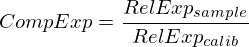

In [18]:
CompExpEq = sp.Eq(
    CompExp,
    RelExp_sample / 
    RelExp_calib
)

CompExpEq

In [112]:
calc_RelExp = lambdify(
    (E_goi, E_ref, Ct_goi, Ct_ref), 
    sp.solvers.solve(RelExpEq, RelExp)[0]
)

calc_CompExp = lambdify(
    (RelExp_sample, RelExp_calib), 
    sp.solvers.solve(CompExpEq, CompExp)[0]
)

In [113]:
GOIs = ["aor", "pta", "fdh", "codh"]
refGenes = ["gyrA", "fhs"]

## Calculate relative expression within each bottle

In [115]:
allRelExps = sampleCts.loc[
    idx[:,GOIs,:,],:
].reset_index(   
).merge(
    sampleCts.loc[
        idx[:,refGenes,:],:
    ].reset_index(), 
    on=["Sample", "Exp_Type", "Replica", "Bottle"],
    suffixes=["_goi", "_ref"]
).groupby(
    by=["GOI_goi"]
).apply(
    lambda outer_df: outer_df.groupby(
            by=["GOI_ref"]
        ).apply(
            lambda inner_df: inner_df.assign(
                RelExp=lambda df: calc_RelExp(
                    efficiencies.loc[outer_df.name], 
                    efficiencies.loc[inner_df.name], 
                    df.Ct_goi, 
                    df.Ct_ref
                )
            )
        )
).rename(
    columns={
        "GOI_goi": "GOI",
        "GOI_ref": "Ref_Gene"
    }
).sort_values(
    by=["Sample", "GOI", "Ref_Gene"]
)

allRelExps

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [122]:
relExps = allRelExps.groupby(["Sample", "Bottle", "GOI", "Replica", "Exp_Type"]).agg({ "RelExp": stats.gmean })

relExps

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [123]:
relExps.to_csv(outPath / "rel-exps_CO2H2.csv")

## Calculate comparative expression from relative expression

In [140]:
compExps = relExps.reset_index().groupby(
    by=["Exp_Type"]
).pipe(
    lambda grouped: grouped.get_group("control").merge(
        grouped.get_group("pressure"), 
        on=["Sample", "GOI"], 
        suffixes=["_calib", "_sample"]
    )
).assign(
    CompExp=lambda x: calc_CompExp(x.RelExp_sample, x.RelExp_calib)
).drop(
    columns=["RelExp_calib", "RelExp_sample", "Bottle_calib", "Exp_Type_calib", "Exp_Type_sample"]
).rename(
    {
        "Bottle_sample": "Bottle"
    },
    axis="columns"
)

ddCts = compExps

compExps

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [127]:
compExps.set_index(
    ["Sample", "Replica_sample", "Replica_calib", "GOI"]
).to_csv(
    outPath / "comp-exps_CO2H2.csv"
)

## Have a look at the ddCts resulting from all combinations of replicas

In [131]:
py.iplot(
    pu.scatterplot_from_df(
        compExps, 
        "Sample", 
        "CompExp", 
        seriesCol="GOI",
        nameCols=["Replica_calib", "Replica_sample"]
    )
)

In [132]:
color_map = {
    "aor": "rgb(120, 0, 50)",
    "pta": "rgb(210, 130, 0)",
    "fdh": "rgb(0, 150, 30)",
    "codh": "rgb(0, 30, 150)"
}

In [139]:
def box_of_expressions():
    grouped_ddCts = compExps.groupby(by="Sample")

    traces = [
        go.Box(
            x=inner_df.GOI,
            y=inner_df.CompExp,
            name=("Sample: %s, GOI: %s"%(sample, goi)),
            marker=dict(
                color=color_map[goi]
            )
        )
        for sample, outer_df in grouped_ddCts if not outer_df.empty
        for goi, inner_df in outer_df.groupby(by="GOI") if not inner_df.empty
    ]

    unique_samples = ddCts.Sample.unique().map(lambda s: "Sample: %s"%(s))
    unique_gois = ddCts.GOI.unique()

    fig = plotly_tools.make_subplots(rows=len(unique_samples), cols=1, subplot_titles=unique_samples)

    for i, trace in enumerate(traces):
        yi = int(np.floor(i / len(unique_gois)))+1
        fig.append_trace(trace, yi, 1)
        fig['layout']['yaxis'+str(yi)].update(title='$\Delta\Delta C_T$ [-]')

    fig['layout'].update(height=1500, showlegend=False)

    py.iplot(fig)
    
box_of_expressions()

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]
[ (6,1) x6,y6 ]



## Calculate mean ddCts and their StDev

In [142]:
mean_ddCts = ddCts.groupby(
    by=["Sample", "GOI"]
).agg(
    {
        "CompExp": ["mean", "std"]
    }
)

mean_ddCts.columns = mean_ddCts.columns.droplevel()
mean_ddCts = mean_ddCts.rename(
    columns={
        "mean": "ddCt_mean",
        "std": "ddCt_std"
    }
).reset_index()

mean_ddCts

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [143]:
def plot_heatmap(): 
    df = mean_ddCts
    
    data = [
        go.Heatmap(
            z=df.ddCt_mean,
            x=df.GOI,
            y=df.Sample.astype(str).map(lambda s: "Sample: %s"%s),
            colorscale='Viridis'
        )
    ]
    
    fig = go.Figure(data=data)
    py.iplot(fig)
    
plot_heatmap()